<a href="https://colab.research.google.com/github/ewerside/olho-no-preco/blob/main/OlhoNoPreco_AP1_Prot%C3%B3tipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OlhoNoPreco — Protótipo AP1 (Extração e Preparação de Dados)

Este notebook documenta a **primeira entrega** do projeto da AP1 na disciplina de *Extração e Preparação de Dados*.

**Integrantes**: Ewerton Arrais, João Gabriel e Miguel Veiga.

**Objetivos desta etapa:**

* Implementar um **baseline** de OCR em foto de cupom/nota (OpenCV + Tesseract) para demonstrar o pipeline e suas limitações.
* Justificar por que **OCR direto de fotos** não é robusto quando escalamos para muitos usuários tirando fotos sem controle de qualidade.
* Apresentar uma **prova de conceito estruturada**: extrair **itens e totais** a partir da **Chave de Acesso** — aqui demonstrado com o **HTML detalhado** exportado do portal da SEFAZ (`nota detalhada.html`), **sem OCR**, navegando no DOM.
* Consolidar as informações em **pandas** (descrição, quantidades, unidades, preços, NCM, etc.) para análises futuras.

## 1. Dependências e setup

Bibliotecas principais usadas neste protótipo:

* `opencv-python` e `numpy` — pré-processamento de imagem (baseline de OCR).
* `pytesseract` — OCR com Tesseract (**requer** o binário Tesseract instalado no sistema).
* `pandas` — estruturação tabular e exportação.
* `beautifulsoup4` + `lxml` — **extração direta do HTML** detalhado da nota (pares `<label> → <span>`).

In [ ]:
! pip install opencv-python-headless numpy pandas pytesseract matplotlib


In [ ]:
import os, pathlib, subprocess
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import pytesseract
from shutil import which
print('Versions -> cv2:', cv2.__version__, '| numpy:', np.__version__, '| pandas:', pd.__version__)

Versions -> cv2: 4.12.0 | numpy: 2.0.2 | pandas: 2.2.2


## 2. Protótipo OCR a partir de uma foto de cupom/nota
Fluxo resumido:
1) **Carregar** a imagem `nota.jpg` (ou similar) e **opcionalmente recortar** a área do QR/rodapé;
2) **Pré-processar** (cinza → *blur* leve → **CLAHE** → *unsharp/threshold adaptativo** quando útil);
3) Aplicar **Tesseract** (`--psm 6` por padrão) para obter texto;

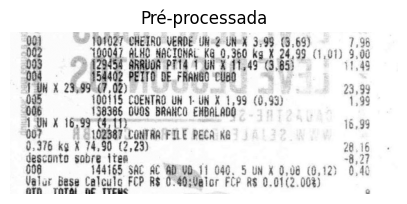


Prévia do OCR (30 primeiras linhas):

001 © $0027 CHETRO VERDE UN? UNeX 3.93 (3,69) 7,98
002 tl a NACIONAL KG 0,360 kg X 24,99 (1,01) 9,00
093 ei tt 1 mas (3,653 11,49
oo Oe PEITO DE FRANGO CUB su
tN X 23,99-07,02) 3 23,99
0 100115 COENTRO UN 1- UN X 1,99 (0,93) 1,99
006 138366 GUOS BRANCO EXBALADO
1 UN X OST eae 16,99
007 ~ © 102387 CONTRA FILE PECA Ke
desconto sobre iten “8,27
008 144165 SAC AC AD UDI] 040. 5 UN XK 0,98 (0,12) 0,46
Valur Base Calcule FCP R$ 0.40;Valor FCP RS 0.01(2.003) ;
AYA TaTai nec TYCkS o


In [ ]:
# Configurações rápidas
path_img = './nota/nota_cortada.jpg'   # ajuste se necessário
lang     = 'por'        # 'por' ou 'por+eng'
psm      = 6            # 4 às vezes funciona melhor em colunas
resize_fx = 1.5
crop_qr   = True

def ensure_tesseract_lang(lang_pref='por'):
    pytesseract.pytesseract.tesseract_cmd = which('tesseract') or '/usr/bin/tesseract'
    def list_langs():
        try:
            out = subprocess.check_output([pytesseract.pytesseract.tesseract_cmd, '--list-langs'], stderr=subprocess.STDOUT, text=True)
            return [ln.strip() for ln in out.splitlines() if ln.strip() and 'List of' not in ln]
        except Exception:
            return []
    if lang_pref in list_langs():
        return lang_pref
    # fallback simplificado: se 'por' não existir, usa 'eng'
    return 'eng'
lang = ensure_tesseract_lang(lang)

def preprocess(img_bgr):
    h, w = img_bgr.shape[:2]
    if crop_qr:
        img_bgr = img_bgr[:int(h*0.72), :]
    if resize_fx != 1.0:
        img_bgr = cv2.resize(img_bgr, None, fx=resize_fx, fy=resize_fx, interpolation=cv2.INTER_CUBIC)
    gray  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray  = cv2.GaussianBlur(gray, (3,3), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enh   = clahe.apply(gray)
    sharp = cv2.addWeighted(enh, 1.5, cv2.GaussianBlur(enh, (0,0), 1.0), -0.5, 0)
    bw    = cv2.adaptiveThreshold(sharp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 5)
    if 0.25 < (bw < 128).mean() < 0.75:
        return bw
    return sharp

def ocr_text(img, lang, psm=6):
    cfg = f'--oem 1 --psm {psm}'
    return pytesseract.image_to_string(img, lang=lang, config=cfg)

if os.path.exists(path_img):
    img_bgr = cv2.imread(path_img)
    pre = preprocess(img_bgr)
    plt.figure(figsize=(5,7)); plt.imshow(pre if pre.ndim==2 else cv2.cvtColor(pre, cv2.COLOR_BGR2RGB), cmap='gray' if pre.ndim==2 else None); plt.axis('off'); plt.title('Pré-processada'); plt.show()
    texto = ocr_text(pre, lang, psm)
    linhas = [ln for ln in texto.splitlines() if ln.strip()]
    print('\nPrévia do OCR (30 primeiras linhas):\n')
    for ln in linhas[:30]:
        print(ln)
else:
    print('Obs.: imagem não encontrada neste ambiente; execute localmente com sua foto.')

## 3. Limitações observadas do OCR em fotos
- **Variação de qualidade** (iluminação, foco, sombra, amassados) quebra a segmentação de linhas.
- **Artefatos visuais** (QR code, carimbos, logos) confundem o OCR e aumentam falsos positivos.
- **Layout heterogêneo** entre mercados exige regras diferentes por loja.
- Em suma: **OCR puro em fotos sem controle de qualidade** tende a falhar quando escalamos para muitos usuários tirando fotos em condições variadas.

## 4. Alternativa: dados estruturados via Chave de Acesso (Prova de Conceito)

A direção é **deixar de depender da foto** e usar a própria **NFC-e/NF-e** acessível pela **Chave de Acesso (44 dígitos)**.

Nesta AP1, **não** implementaremos a coleta automática (não há API oficial simples). Para **demonstrar a viabilidade**, salvamos o **HTML detalhado** da consulta pública da SEFAZ (`nota detalhada.html`) e extraímos os campos de produto/nota **navegando no DOM** (pares `label → span` e classes CSS), **sem OCR** e **sem regex**. O objetivo é comprovar que os itens podem ser capturados de forma estruturada (descrição, quantidades, unidade, valor unitário/total, NCM etc.).

## 5. Extração de Itens da NF-e a partir do HTML da SEFAZ

Nesta seção carregamos o arquivo “nota detalhada.html” e extraímos os produtos navegando no DOM com BeautifulSoup. Usamos as tabelas de resumo dentro da aba “Produtos e Serviços” e a tabela de detalhes que as sucede para mapear pares `<label> → <span>` e coletar descrição, quantidades, unidades, valor do item, código do produto, NCM, unidade e quantidade comerciais, valor unitário e os campos derivados `valor_item_calc` e `valor_item_final`. Essa abordagem elimina OCR, é mais determinística e tende a ser mais robusta para demonstração.

In [ ]:
# Extração só por tags/classes — colunas solicitadas
import math, unicodedata, pandas as pd
from bs4 import BeautifulSoup

html_path = "./nota/nota detalhada.html"  # ajuste se preciso
soup = BeautifulSoup(open(html_path, encoding="utf-8").read(), "lxml")

def txt(s): return " ".join((s or "").split())
def br2f(s):
    if not s: return math.nan
    s = txt(s).replace("\xa0"," ").replace(" ","").replace(".","").replace(",",".")
    try: return float(s)
    except: return math.nan
def normlabel(s):
    s = txt(s).lower()
    s = unicodedata.normalize("NFD", s)
    return "".join(ch for ch in s if unicodedata.category(ch) != "Mn")

def seltext(root, css):
    el = root.select_one(css)
    return txt(el.get_text()) if el else None

def next_detail_table(summary_table):
    n = summary_table
    while True:
        n = n.find_next_sibling()
        if n is None: return None
        if getattr(n, "name", None) != "table": continue
        cls = set(n.get("class") or [])
        if {"toggle","box","opened"}.issubset(cls):  # próximo item; não há detalhes
            return None
        if {"toggable","box"}.issubset(cls):        # tabela de detalhes do item atual
            return n

cols = ["descricao","quantidade","unidade","valor_item",
        "codigo_produto","ncm","unidade_comercial","quantidade_comercial",
        "valor_unitario","valor_item_calc","valor_item_final"]

items = []
prod = soup.find(id="Prod")
for t in (prod.select("table.toggle.box.opened") if prod else []):
    r = {
        "descricao":            seltext(t, ".fixo-prod-serv-descricao span"),
        "quantidade":           br2f(seltext(t, ".fixo-prod-serv-qtd span")),
        "unidade":              seltext(t, ".fixo-prod-serv-uc span"),
        "valor_item":           br2f(seltext(t, ".fixo-prod-serv-vb span")),
        "codigo_produto":       None,
        "ncm":                  None,
        "unidade_comercial":    None,
        "quantidade_comercial": math.nan,
        "valor_unitario":       math.nan,
        "valor_item_calc":      math.nan,
        "valor_item_final":     math.nan,
    }
    det = next_detail_table(t)
    if det:
        for lab in det.find_all("label"):
            k = normlabel(lab.get_text())
            sp = lab.find_next("span"); v = txt(sp.get_text()) if sp else None
            if "codigo do produto" in k:          r["codigo_produto"] = v
            elif k == "ncm" or "codigo ncm" in k: r["ncm"] = v
            elif "unidade comercial" in k:        r["unidade_comercial"] = v
            elif "quantidade comercial" in k:     r["quantidade_comercial"] = br2f(v)
            elif "valor unitario" in k:           r["valor_unitario"] = br2f(v)

    q = r["quantidade_comercial"] if not math.isnan(r["quantidade_comercial"]) else r["quantidade"]
    if not math.isnan(q) and not math.isnan(r["valor_unitario"]):
        r["valor_item_calc"] = round(q * r["valor_unitario"], 2)
    r["valor_item_final"] = r["valor_item"] if not math.isnan(r["valor_item"]) else r["valor_item_calc"]
    items.append(r)

df = pd.DataFrame(items, columns=cols)
df


,descricao,quantidade,unidade,valor_item,codigo_produto,ncm,unidade_comercial,quantidade_comercial,valor_unitario,valor_item_calc,valor_item_final
0,CHEIRO VERDE UN,2.000,UN,7.98,101027,07099990,UN,2.000,3.99,7.98,7.98
1,ALHO NACIONAL KG,0.360,kg,9.00,100047,07032090,kg,0.360,24.99,9.00,9.00
2,ARRUDA PT14,1.000,UN,11.49,129454,06029090,UN,1.000,11.49,11.49,11.49
3,PEITO DE FRANGO CUBO,1.000,UN,23.99,154402,02071422,UN,1.000,23.99,23.99,23.99
4,COENTRO UN,1.000,UN,1.99,100115,07099990,UN,1.000,1.99,1.99,1.99
5,OVOS BRANCO EMBALADO,1.000,UN,16.99,138386,04072100,UN,1.000,16.99,16.99,16.99
6,CONTRA FILE PECA KG,0.376,kg,28.16,102387,02012020,kg,0.376,74.90,28.16,28.16
7,SAC AC AD VD 11 040.,5.000,UN,0.40,144165,39232190,UN,5.000,0.08,0.40,0.40


## 8. Conclusão (próximos passos do projeto)
Para finalizar o **OlhoNoPreco** na disciplina, precisamos:
1. **Automatizar** a recuperação das informações estruturadas da nota via **Chave de Acesso** (ex.: *scraping* robusto/serviço intermediário), respeitando limites legais;
2. **Vincular representações** diferentes do **mesmo produto** entre mercados (normalização de nomes, mapeamento por **NCM/EAN** + *string matching*/embeddings);
3. **Aplicativo final** para o consumidor: busca/escaneamento de produto e comparação de preços próximos (detalhes de UX serão definidos depois).